In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import simple_solver as ss

In [2]:
# Open a 'CLEAR' exposure from CV3.
stack = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Gaussian_model/InputFiles/CleanStack.fits')[0].data
stack[np.where(np.isnan(stack))] = 0

In [4]:
# Data centroids
xc, yc, xc2, yc2, rot_par = ss.get_contam_centroids(stack, return_rot_params=True)

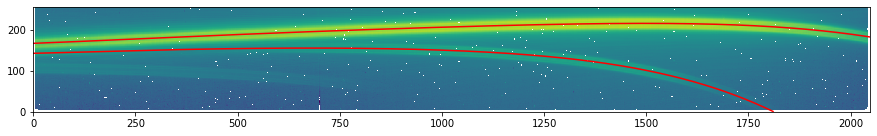

In [4]:
plt.figure(figsize=(15, 3))
plt.imshow(np.log10(stack), origin='lower')
plt.plot(xc, yc, c='red')
plt.plot(xc2, yc2, c='red')

In [6]:
rotframe_o1 = ss.simple_solver(xc, yc, order=1)
rotframe_o2 = ss.simple_solver(xc2, yc2, order=2)

In [11]:
# Optics model centroids
xom1, yom1, tps = ss.get_om_centroids(atthesex=np.arange(2048), order=1)
xom2, yom2, tps = ss.get_om_centroids(atthesex=np.arange(2048), order=2)

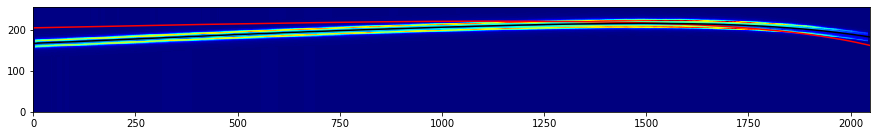

In [12]:
plt.figure(figsize=(15, 3))
plt.imshow(rotframe_o1, origin='lower', cmap='jet')
plt.plot(xom1, yom1, c='red')
plt.plot(xc, yc, c='black')

(0, 256)

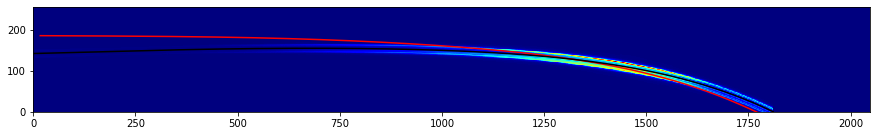

In [15]:
plt.figure(figsize=(15, 3))
plt.imshow(rotframe_o2, origin='lower', cmap='jet')
plt.plot(xom2, yom2, c='red')
plt.plot(xc2, yc2, c='black')
plt.ylim(0,256)